# Analisis Kanibalisasi Produk Sunsilk (PC001 vs PC013)

Analisis mendalam untuk mengidentifikasi apakah peluncuran PC013 (Sunsilk kondisioner) mengkanibalisasi PC001 (Sunsilk shampoo) dengan membandingkan:
- **Sales Trend**: Volume dan revenue sebelum & sesudah peluncuran
- **Marketing Support**: Strategi dan spend marketing per produk
- **Customer Reviews**: Sentiment dan rating pelanggan
- **Statistical Correlation**: Hubungan negatif antara kedua produk


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

# Diagnostic + auto-detect data directory
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

cwd = os.getcwd()
print('Notebook working directory:', cwd)

candidates = [
    os.path.join(cwd, 'fmcg_personalcare'),
    cwd
]

data_dir = None
for cand in candidates:
    # check if required files exist in this candidate dir
    if all(os.path.exists(os.path.join(cand, fn)) for fn in ['sales.csv','products.csv','marketing.csv','reviews.csv']):
        data_dir = cand
        break

print('Auto-detected data_dir:', data_dir)
if data_dir is None:
    print('Checked candidate dirs:')
    for cand in candidates:
        print(' -', cand, 'exists?', os.path.exists(cand))
    raise FileNotFoundError('Could not find data files in expected locations; please place CSVs in workspace root or fmcg_personalcare subfolder')

# show listing
print('\nData dir listing sample:', os.listdir(data_dir)[:50])

# Load files
sales = pd.read_csv(os.path.join(data_dir, 'sales.csv'))
products = pd.read_csv(os.path.join(data_dir, 'products.csv'))
marketing = pd.read_csv(os.path.join(data_dir, 'marketing.csv'))
reviews = pd.read_csv(os.path.join(data_dir, 'reviews.csv'))

# Data preparation
sales['date'] = pd.to_datetime(sales['date'])
products['launch_date'] = pd.to_datetime(products['launch_date'])
marketing['start_date'] = pd.to_datetime(marketing['start_date'])
marketing['end_date'] = pd.to_datetime(marketing['end_date'])
reviews['date'] = pd.to_datetime(reviews['date'])

print("\n✓ Data loaded successfully")
print(f"Sales records: {len(sales)}")
print(f"Products: {len(products)}")
print(f"Marketing campaigns: {len(marketing)}")
print(f"Reviews: {len(reviews)}")


Notebook working directory: c:\Users\ASUS\Visual Studio\dana\lomba
Auto-detected data_dir: c:\Users\ASUS\Visual Studio\dana\lomba

Data dir listing sample: ['.git', '.venv', '01_sales_trend_lineplot.png', '01_yearly_trend.png', '02_monthly_trend.png', '02_sales_boxplot_comparison.png', '03_marketing_comparison.png', '04_reviews_sentiment_analysis.png', '05_weekly_correlation_analysis.png', 'DSC2025_Siapa_Rifai.ipynb', 'innovation_radar.ipynb', 'marketing.csv', 'products.csv', 'product_cannibalization_analysis.ipynb', 'README.md', 'requirements.txt', 'reviews.csv', 'sales.csv', 'siapa.py', 'trend_forecasting.ipynb', '__pycache__']

✓ Data loaded successfully
Sales records: 1000000
Products: 15
Marketing campaigns: 20
Reviews: 10000


## 1. Product Overview & Launch Dates

In [3]:
# Focus on PC001 and PC013 (both Sunsilk)
PC001_info = products[products['product_id']=='PC001'].iloc[0]
PC013_info = products[products['product_id']=='PC013'].iloc[0]

print("=" * 60)
print("PRODUCT INFORMATION")
print("=" * 60)
print(f"\nPC001 (Incumbent): {PC001_info['product_name']}")
print(f"   Brand: {PC001_info['brand']}, Type: {PC001_info['type']}")
print(f"   Launch Date: {PC001_info['launch_date'].strftime('%Y-%m-%d')}")
print(f"   Base Price: IDR {PC001_info['base_price']:,.0f}")

print(f"\nPC013 (New Product): {PC013_info['product_name']}")
print(f"   Brand: {PC013_info['brand']}, Type: {PC013_info['type']}")
print(f"   Launch Date: {PC013_info['launch_date'].strftime('%Y-%m-%d')}")
print(f"   Base Price: IDR {PC013_info['base_price']:,.0f}")

launch_pc013 = PC013_info['launch_date']
launch_pc001 = PC001_info['launch_date']
days_apart = (launch_pc013 - launch_pc001).days

print(f"\nPC013 launched {days_apart} days after PC001")


PRODUCT INFORMATION

PC001 (Incumbent): Sunsilk Smooth & Shine Shampoo 340ml
   Brand: Sunsilk, Type: Shampoo
   Launch Date: 2020-02-15
   Base Price: IDR 32,000

PC013 (New Product): Sunsilk Anti Hairfall Shampoo 340ml
   Brand: Sunsilk, Type: Shampoo
   Launch Date: 2024-01-15
   Base Price: IDR 32,000

PC013 launched 1430 days after PC001


## 2. Sales Comparison: PC001 vs PC013

In [4]:
# Extract sales for both products
sales_pc001 = sales[sales['product_id']=='PC001'].copy()
sales_pc013 = sales[sales['product_id']=='PC013'].copy()

# Daily aggregation
daily_pc001 = sales_pc001.groupby('date').agg({
    'units_sold': 'sum',
    'revenue': 'sum',
    'discount_pct': 'mean'
}).reset_index()

daily_pc013 = sales_pc013.groupby('date').agg({
    'units_sold': 'sum',
    'revenue': 'sum',
    'discount_pct': 'mean'
}).reset_index()

# Weekly aggregation
weekly_pc001 = daily_pc001.set_index('date').resample('W').agg({
    'units_sold': 'sum',
    'revenue': 'sum',
    'discount_pct': 'mean'
}).reset_index()

weekly_pc013 = daily_pc013.set_index('date').resample('W').agg({
    'units_sold': 'sum',
    'revenue': 'sum',
    'discount_pct': 'mean'
}).reset_index()

print("\n" + "=" * 60)
print("SALES STATISTICS")
print("=" * 60)
print(f"\nPC001 - Total transactions: {len(sales_pc001)}")
print(f"  Revenue: IDR {sales_pc001['revenue'].sum():,.0f}")
print(f"  Units Sold: {sales_pc001['units_sold'].sum():,.0f}")
print(f"  Avg Discount: {sales_pc001['discount_pct'].mean():.1f}%")

print(f"\nPC013 - Total transactions: {len(sales_pc013)}")
print(f"  Revenue: IDR {sales_pc013['revenue'].sum():,.0f}")
print(f"  Units Sold: {sales_pc013['units_sold'].sum():,.0f}")
print(f"  Avg Discount: {sales_pc013['discount_pct'].mean():.1f}%")

# Define analysis window: 180 days before and after PC013 launch
window_start = launch_pc013 - pd.Timedelta(days=180)
window_end = launch_pc013 + pd.Timedelta(days=180)

# Split PC001 sales: before and after PC013 launch
pc001_before = daily_pc001[(daily_pc001['date'] >= window_start) & 
                            (daily_pc001['date'] < launch_pc013)]
pc001_after = daily_pc001[(daily_pc001['date'] >= launch_pc013) & 
                           (daily_pc001['date'] <= window_end)]

print(f"\nPC001 Before PC013 Launch:")
print(f"  Avg Daily Revenue: IDR {pc001_before['revenue'].mean():,.0f}")
print(f"  Avg Daily Units: {pc001_before['units_sold'].mean():.1f}")

print(f"\PC001 After PC013 Launch (180 days):")
print(f"  Avg Daily Revenue: IDR {pc001_after['revenue'].mean():,.0f}")
print(f"  Avg Daily Units: {pc001_after['units_sold'].mean():.1f}")

pct_change = ((pc001_after['revenue'].mean() - pc001_before['revenue'].mean()) / 
              pc001_before['revenue'].mean() * 100)
print(f"Change: {pct_change:+.1f}%")



SALES STATISTICS

PC001 - Total transactions: 66804
  Revenue: IDR 8,009,993,651
  Units Sold: 267,482
  Avg Discount: 5.0%

PC013 - Total transactions: 66744
  Revenue: IDR 7,999,288,746
  Units Sold: 267,098
  Avg Discount: 5.0%

🔍 PC001 Before PC013 Launch:
  Avg Daily Revenue: IDR 3,567,712
  Avg Daily Units: 119.4

🔍 PC001 After PC013 Launch (180 days):
  Avg Daily Revenue: IDR 3,595,868
  Avg Daily Units: 119.9
  📊 Change: +0.8%


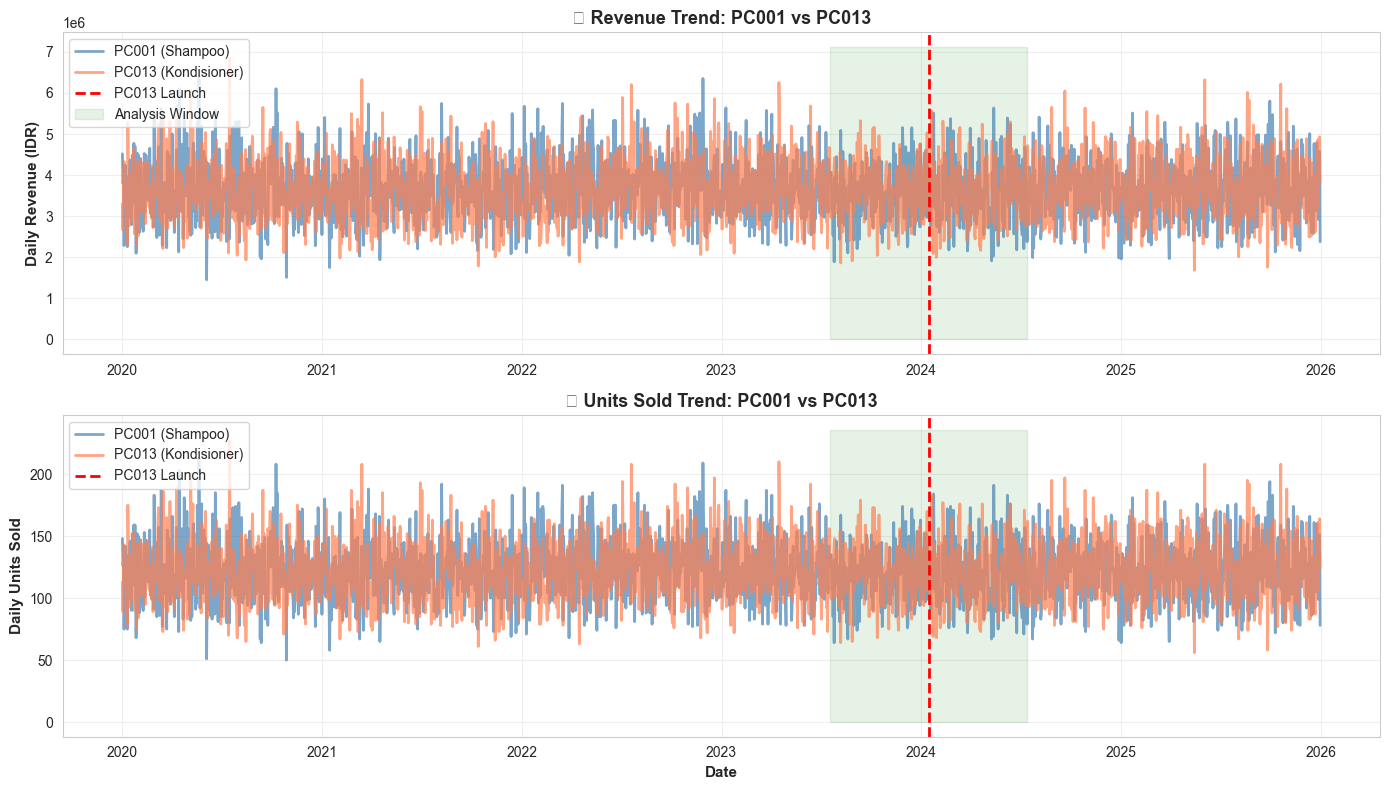

✓ Line chart saved: 01_sales_trend_lineplot.png


In [5]:
# LINE CHART: Sales Trend Over Time
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Revenue trend
axes[0].plot(daily_pc001['date'], daily_pc001['revenue'], 
            label='PC001 (Shampoo)', color='steelblue', linewidth=2, alpha=0.7)
axes[0].plot(daily_pc013['date'], daily_pc013['revenue'], 
            label='PC013 (Kondisioner)', color='coral', linewidth=2, alpha=0.7)
axes[0].axvline(launch_pc013, color='red', linestyle='--', linewidth=2, label='PC013 Launch')
axes[0].fill_between([window_start, window_end], 0, axes[0].get_ylim()[1], 
                      alpha=0.1, color='green', label='Analysis Window')
axes[0].set_ylabel('Daily Revenue (IDR)', fontsize=11, fontweight='bold')
axes[0].set_title('Revenue Trend: PC001 vs PC013', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Units sold trend
axes[1].plot(daily_pc001['date'], daily_pc001['units_sold'], 
            label='PC001 (Shampoo)', color='steelblue', linewidth=2, alpha=0.7)
axes[1].plot(daily_pc013['date'], daily_pc013['units_sold'], 
            label='PC013 (Kondisioner)', color='coral', linewidth=2, alpha=0.7)
axes[1].axvline(launch_pc013, color='red', linestyle='--', linewidth=2, label='PC013 Launch')
axes[1].fill_between([window_start, window_end], 0, axes[1].get_ylim()[1], 
                      alpha=0.1, color='green')
axes[1].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Daily Units Sold', fontsize=11, fontweight='bold')
axes[1].set_title('Units Sold Trend: PC001 vs PC013', fontsize=13, fontweight='bold')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('01_sales_trend_lineplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Line chart saved: 01_sales_trend_lineplot.png")


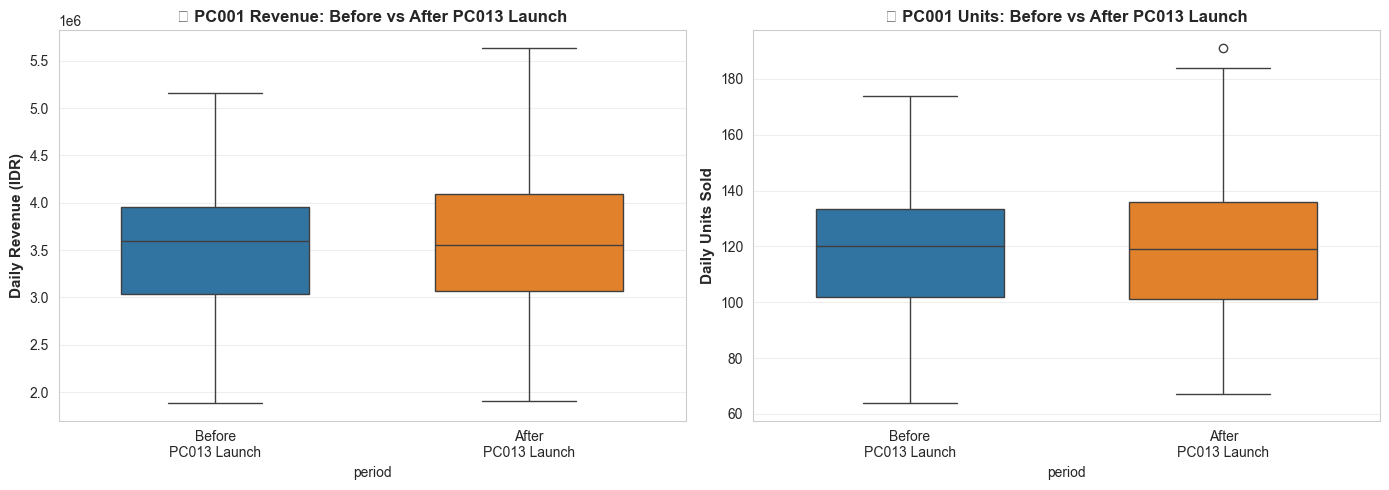

✓ Boxplot saved: 02_sales_boxplot_comparison.png


In [6]:
# BOXPLOT: Compare Revenue Distribution Before vs After
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prepare data for boxplot
pc001_before['period'] = 'Before\nPC013 Launch'
pc001_after['period'] = 'After\nPC013 Launch'
boxplot_data = pd.concat([
    pc001_before[['revenue', 'period']],
    pc001_after[['revenue', 'period']]
])

# Revenue boxplot
sns.boxplot(data=boxplot_data, x='period', y='revenue', ax=axes[0], 
           palette=['#1f77b4', '#ff7f0e'], width=0.6)
axes[0].set_ylabel('Daily Revenue (IDR)', fontsize=11, fontweight='bold')
axes[0].set_title('PC001 Revenue: Before vs After PC013 Launch', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Units boxplot
pc001_before_u = pc001_before.copy()
pc001_after_u = pc001_after.copy()
pc001_before_u['period'] = 'Before\nPC013 Launch'
pc001_after_u['period'] = 'After\nPC013 Launch'
boxplot_data_u = pd.concat([
    pc001_before_u[['units_sold', 'period']],
    pc001_after_u[['units_sold', 'period']]
])

sns.boxplot(data=boxplot_data_u, x='period', y='units_sold', ax=axes[1], 
           palette=['#1f77b4', '#ff7f0e'], width=0.6)
axes[1].set_ylabel('Daily Units Sold', fontsize=11, fontweight='bold')
axes[1].set_title('PC001 Units: Before vs After PC013 Launch', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('02_sales_boxplot_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Boxplot saved: 02_sales_boxplot_comparison.png")


## 3. Marketing Support Analysis

In [7]:
# Marketing data for both products
mk_pc001 = marketing[marketing['product_id']=='PC001']
mk_pc013 = marketing[marketing['product_id']=='PC013']

print("\n" + "=" * 60)
print("MARKETING CAMPAIGNS")
print("=" * 60)

if len(mk_pc001) > 0:
    print(f"\nPC001 Marketing Campaigns: {len(mk_pc001)}")
    for idx, row in mk_pc001.iterrows():
        print(f"  • {row['campaign_name']}")
        print(f"    Spend: IDR {row['spend_idr']:,.0f} | Channel: {row['channel']}")
        print(f"    Engagement: {row['engagement_rate']:.1%} | Duration: {(row['end_date']-row['start_date']).days} days")
    total_mk_pc001 = mk_pc001['spend_idr'].sum()
    print(f"Total Spend PC001: IDR {total_mk_pc001:,.0f}")
else:
    print("\nPC001: No marketing campaigns found")
    total_mk_pc001 = 0

if len(mk_pc013) > 0:
    print(f"\nPC013 Marketing Campaigns: {len(mk_pc013)}")
    for idx, row in mk_pc013.iterrows():
        print(f"  • {row['campaign_name']}")
        print(f"    Spend: IDR {row['spend_idr']:,.0f} | Channel: {row['channel']}")
        print(f"    Engagement: {row['engagement_rate']:.1%} | Duration: {(row['end_date']-row['start_date']).days} days")
    total_mk_pc013 = mk_pc013['spend_idr'].sum()
    print(f"Total Spend PC013: IDR {total_mk_pc013:,.0f}")
else:
    print("\nPC013: No marketing campaigns found")
    total_mk_pc013 = 0

# Compare
print(f"\nComparison:")
print(f"  PC001 Total Spend: IDR {total_mk_pc001:,.0f}")
print(f"  PC013 Total Spend: IDR {total_mk_pc013:,.0f}")
if total_mk_pc001 > 0:
    ratio = total_mk_pc013 / total_mk_pc001
    print(f"  Ratio (PC013/PC001): {ratio:.2f}x")



MARKETING CAMPAIGNS

🎯 PC001 Marketing Campaigns: 1
  • Campaign_13_PC001
    Spend: IDR 717,751,350 | Channel: Instagram
    Engagement: 42.2% | Duration: 44 days
  📊 Total Spend PC001: IDR 717,751,350

🎯 PC013 Marketing Campaigns: 1
  • Campaign_19_PC013
    Spend: IDR 495,290,588 | Channel: TikTok
    Engagement: 45.7% | Duration: 33 days
  📊 Total Spend PC013: IDR 495,290,588

💡 Comparison:
  PC001 Total Spend: IDR 717,751,350
  PC013 Total Spend: IDR 495,290,588
  Ratio (PC013/PC001): 0.69x


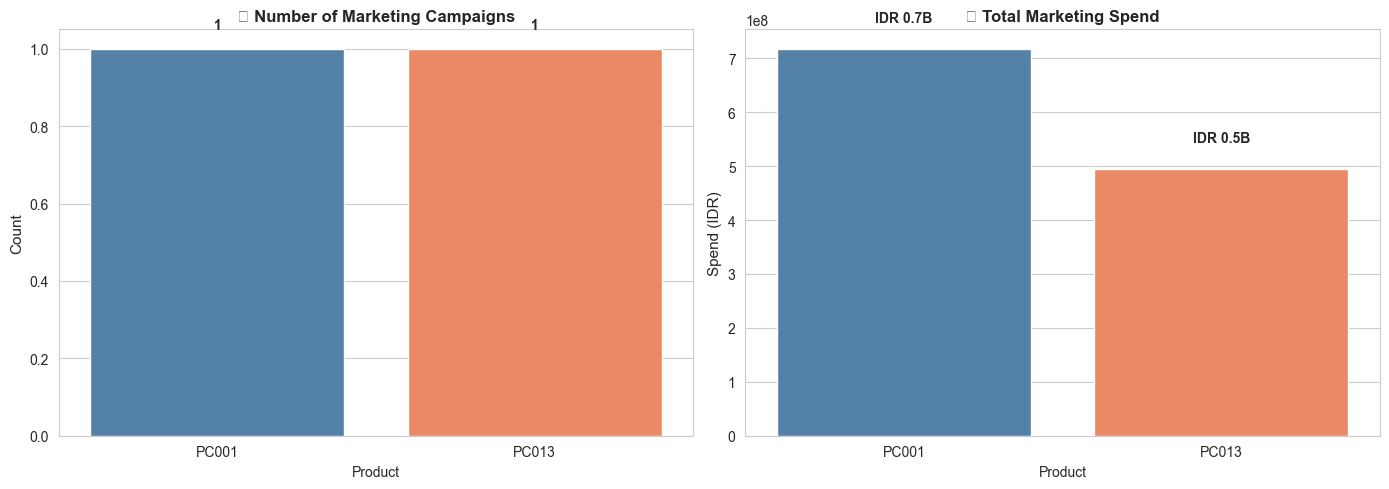

✓ Marketing chart saved: 03_marketing_comparison.png


In [8]:
# Marketing visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Campaign count
campaigns_data = pd.DataFrame({
    'Product': ['PC001', 'PC013'],
    'Campaigns': [len(mk_pc001), len(mk_pc013)]
})
sns.barplot(data=campaigns_data, x='Product', y='Campaigns', ax=axes[0], 
           palette=['steelblue', 'coral'])
axes[0].set_title('Number of Marketing Campaigns', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=11)
for i, v in enumerate(campaigns_data['Campaigns']):
    axes[0].text(i, v + 0.05, str(int(v)), ha='center', fontweight='bold')

# Total spend
spend_data = pd.DataFrame({
    'Product': ['PC001', 'PC013'],
    'Spend': [total_mk_pc001, total_mk_pc013]
})
sns.barplot(data=spend_data, x='Product', y='Spend', ax=axes[1], 
           palette=['steelblue', 'coral'])
axes[1].set_title('Total Marketing Spend', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Spend (IDR)', fontsize=11)
for i, v in enumerate(spend_data['Spend']):
    axes[1].text(i, v + 50e6, f'IDR {v/1e9:.1f}B', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('03_marketing_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Marketing chart saved: 03_marketing_comparison.png")


## 4. Customer Reviews & Sentiment Analysis

In [9]:
# Review analysis for both products
rev_pc001 = reviews[reviews['product_id']=='PC001']
rev_pc013 = reviews[reviews['product_id']=='PC013']

print("\n" + "=" * 60)
print("CUSTOMER REVIEWS & SENTIMENT")
print("=" * 60)

print(f"\nPC001 Reviews: {len(rev_pc001)} reviews")
print(f"  Avg Rating: {rev_pc001['rating'].mean():.2f} / 5.0")
print(f"  Sentiment Distribution:")
print(f"    Positive: {(rev_pc001['sentiment']=='Positive').sum()} ({(rev_pc001['sentiment']=='Positive').sum()/len(rev_pc001)*100:.1f}%)")
print(f"    Neutral:  {(rev_pc001['sentiment']=='Neutral').sum()} ({(rev_pc001['sentiment']=='Neutral').sum()/len(rev_pc001)*100:.1f}%)")
print(f"    Negative: {(rev_pc001['sentiment']=='Negative').sum()} ({(rev_pc001['sentiment']=='Negative').sum()/len(rev_pc001)*100:.1f}%)")

print(f"\nPC013 Reviews: {len(rev_pc013)} reviews")
print(f"  Avg Rating: {rev_pc013['rating'].mean():.2f} / 5.0")
print(f"  Sentiment Distribution:")
print(f"    Positive: {(rev_pc013['sentiment']=='Positive').sum()} ({(rev_pc013['sentiment']=='Positive').sum()/len(rev_pc013)*100:.1f}%)")
print(f"    Neutral:  {(rev_pc013['sentiment']=='Neutral').sum()} ({(rev_pc013['sentiment']=='Neutral').sum()/len(rev_pc013)*100:.1f}%)")
print(f"    Negative: {(rev_pc013['sentiment']=='Negative').sum()} ({(rev_pc013['sentiment']=='Negative').sum()/len(rev_pc013)*100:.1f}%)")

# Top platforms
print(f"\nTop Platforms:")
print(f"  PC001: {rev_pc001['platform'].value_counts().to_dict()}")
print(f"  PC013: {rev_pc013['platform'].value_counts().to_dict()}")



CUSTOMER REVIEWS & SENTIMENT

⭐ PC001 Reviews: 659 reviews
  Avg Rating: 3.03 / 5.0
  Sentiment Distribution:
    Positive: 177 (26.9%)
    Neutral:  165 (25.0%)
    Negative: 317 (48.1%)

⭐ PC013 Reviews: 689 reviews
  Avg Rating: 3.03 / 5.0
  Sentiment Distribution:
    Positive: 195 (28.3%)
    Neutral:  156 (22.6%)
    Negative: 338 (49.1%)

📱 Top Platforms:
  PC001: {'Shopee': 179, 'Official Store': 165, 'Instagram': 163, 'Tokopedia': 152}
  PC013: {'Instagram': 193, 'Official Store': 191, 'Tokopedia': 163, 'Shopee': 142}


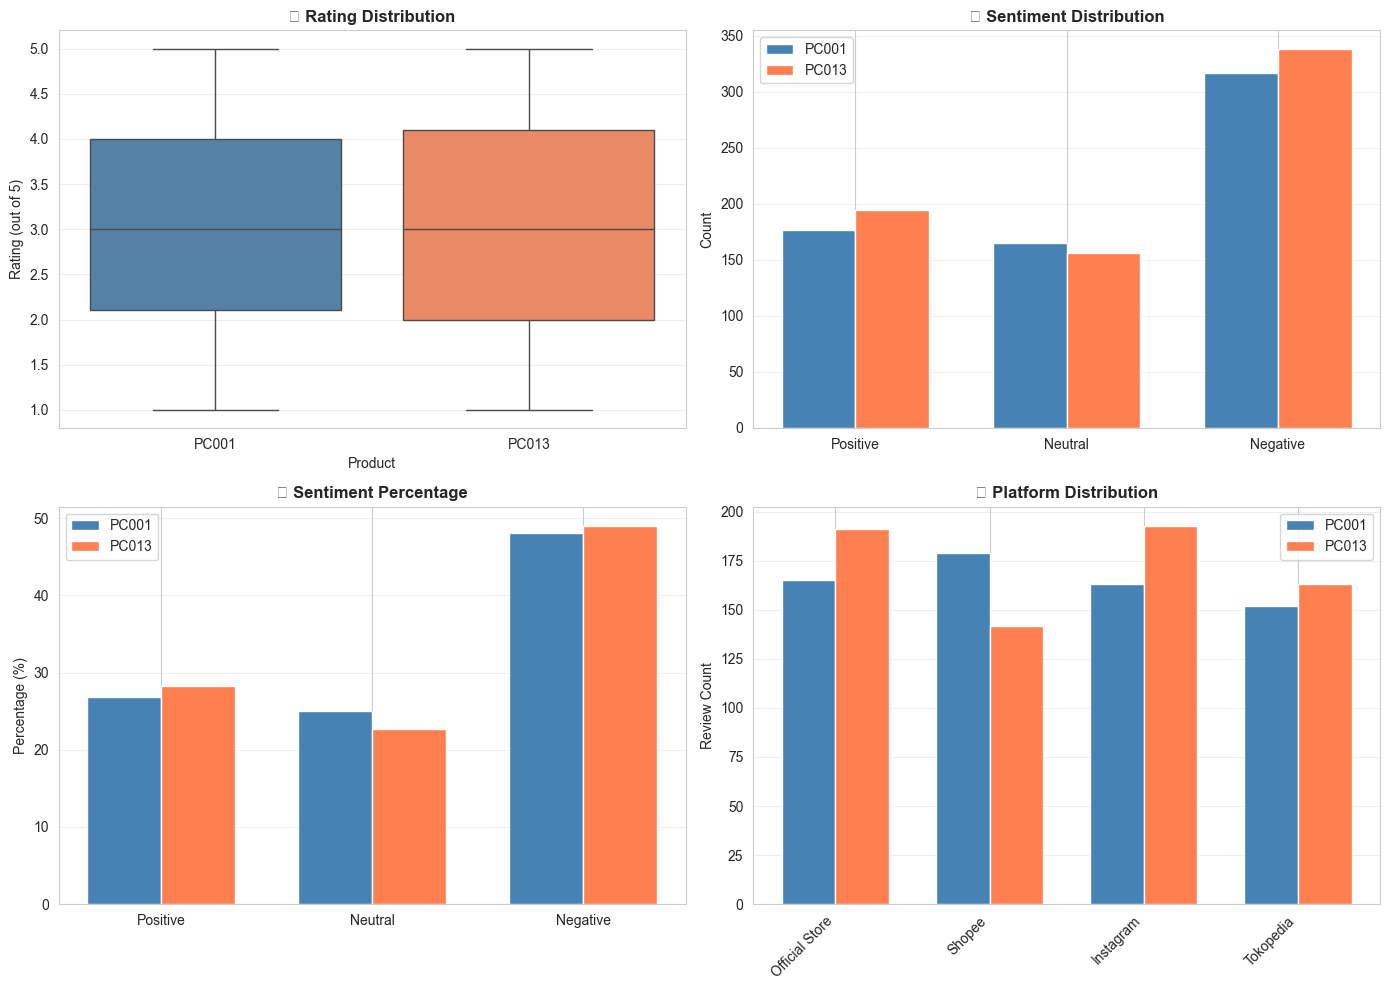

✓ Review chart saved: 04_reviews_sentiment_analysis.png


In [10]:
# Sentiment visualization - BOXPLOT & BAR
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Rating boxplot comparison
rating_data = pd.concat([
    rev_pc001[['rating']].assign(Product='PC001'),
    rev_pc013[['rating']].assign(Product='PC013')
])
sns.boxplot(data=rating_data, x='Product', y='rating', ax=axes[0, 0], 
           palette=['steelblue', 'coral'])
axes[0, 0].set_title('Rating Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Rating (out of 5)', fontsize=10)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Sentiment distribution
sentiment_counts_pc001 = rev_pc001['sentiment'].value_counts()
sentiment_counts_pc013 = rev_pc013['sentiment'].value_counts()

sentiments = ['Positive', 'Neutral', 'Negative']
pc001_vals = [sentiment_counts_pc001.get(s, 0) for s in sentiments]
pc013_vals = [sentiment_counts_pc013.get(s, 0) for s in sentiments]

x = np.arange(len(sentiments))
width = 0.35
axes[0, 1].bar(x - width/2, pc001_vals, width, label='PC001', color='steelblue')
axes[0, 1].bar(x + width/2, pc013_vals, width, label='PC013', color='coral')
axes[0, 1].set_ylabel('Count', fontsize=10)
axes[0, 1].set_title('Sentiment Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(sentiments)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Sentiment percentage
pc001_pct = [sentiment_counts_pc001.get(s, 0)/len(rev_pc001)*100 for s in sentiments]
pc013_pct = [sentiment_counts_pc013.get(s, 0)/len(rev_pc013)*100 for s in sentiments]

axes[1, 0].bar(x - width/2, pc001_pct, width, label='PC001', color='steelblue')
axes[1, 0].bar(x + width/2, pc013_pct, width, label='PC013', color='coral')
axes[1, 0].set_ylabel('Percentage (%)', fontsize=10)
axes[1, 0].set_title('Sentiment Percentage', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(sentiments)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Platform distribution
platform_pc001 = rev_pc001['platform'].value_counts()
platform_pc013 = rev_pc013['platform'].value_counts()
all_platforms = list(set(platform_pc001.index) | set(platform_pc013.index))

platform_pc001_vals = [platform_pc001.get(p, 0) for p in all_platforms]
platform_pc013_vals = [platform_pc013.get(p, 0) for p in all_platforms]

x_plat = np.arange(len(all_platforms))
axes[1, 1].bar(x_plat - width/2, platform_pc001_vals, width, label='PC001', color='steelblue')
axes[1, 1].bar(x_plat + width/2, platform_pc013_vals, width, label='PC013', color='coral')
axes[1, 1].set_ylabel('Review Count', fontsize=10)
axes[1, 1].set_title('📱 Platform Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_plat)
axes[1, 1].set_xticklabels(all_platforms, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('04_reviews_sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Review chart saved: 04_reviews_sentiment_analysis.png")


## 5. Cannibalization Detection - Weekly Analysis

In [11]:
# Extract weekly data around the launch period
weekly_analysis_start = launch_pc013 - pd.Timedelta(days=180)
weekly_analysis_end = launch_pc013 + pd.Timedelta(days=180)

weekly_pc001_window = weekly_pc001[
    (weekly_pc001['date'] >= weekly_analysis_start) & 
    (weekly_pc001['date'] <= weekly_analysis_end)
].copy()

weekly_pc013_window = weekly_pc013[
    (weekly_pc013['date'] >= weekly_analysis_start) & 
    (weekly_pc013['date'] <= weekly_analysis_end)
].copy()

# Merge weekly data
weekly_merged = pd.merge(
    weekly_pc001_window[['date', 'revenue', 'units_sold']].rename(
        columns={'revenue': 'revenue_pc001', 'units_sold': 'units_pc001'}),
    weekly_pc013_window[['date', 'revenue', 'units_sold']].rename(
        columns={'revenue': 'revenue_pc013', 'units_sold': 'units_pc013'}),
    on='date',
    how='outer'
).fillna(0).sort_values('date')

# Calculate correlation
if len(weekly_merged) > 2:
    corr_revenue = weekly_merged[['revenue_pc001', 'revenue_pc013']].corr().iloc[0, 1]
    corr_units = weekly_merged[['units_pc001', 'units_pc013']].corr().iloc[0, 1]
else:
    corr_revenue = np.nan
    corr_units = np.nan

print("\n" + "=" * 60)
print("CANNIBALIZATION ANALYSIS (Weekly Data)")
print("=" * 60)
print(f"\nAnalysis Period: {weekly_analysis_start.date()} to {weekly_analysis_end.date()}")
print(f"   Weeks analyzed: {len(weekly_merged)}")
print(f"\nCorrelation Metrics:")
print(f"   Revenue Correlation: {corr_revenue:.3f}")
print(f"   Units Correlation:   {corr_units:.3f}")

if corr_revenue < -0.3:
    print(f"\nSTRONG NEGATIVE CORRELATION DETECTED!")
    print(f"    → Suggests possible cannibalization (revenue)")
elif corr_revenue < 0:
    print(f"\nWEAK NEGATIVE CORRELATION")
    print(f"    → Some cannibalization signals (revenue)")
else:
    print(f"\nNo clear cannibalization signal (revenue)")

print(f"\nWeekly Summary Statistics:")
print(f"   PC001 Avg Weekly Revenue: IDR {weekly_pc001_window['revenue'].mean():,.0f}")
print(f"   PC013 Avg Weekly Revenue: IDR {weekly_pc013_window['revenue'].mean():,.0f}")
print(f"   PC001 Avg Weekly Units: {weekly_pc001_window['units_sold'].mean():.1f}")
print(f"   PC013 Avg Weekly Units: {weekly_pc013_window['units_sold'].mean():.1f}")



CANNIBALIZATION ANALYSIS (Weekly Data)

📊 Analysis Period: 2023-07-19 to 2024-07-13
   Weeks analyzed: 51

🔗 Correlation Metrics:
   Revenue Correlation: -0.097
   Units Correlation:   -0.080

⚠️  WEAK NEGATIVE CORRELATION
    → Some cannibalization signals (revenue)

📈 Weekly Summary Statistics:
   PC001 Avg Weekly Revenue: IDR 25,074,280
   PC013 Avg Weekly Revenue: IDR 25,311,346
   PC001 Avg Weekly Units: 837.6
   PC013 Avg Weekly Units: 845.2


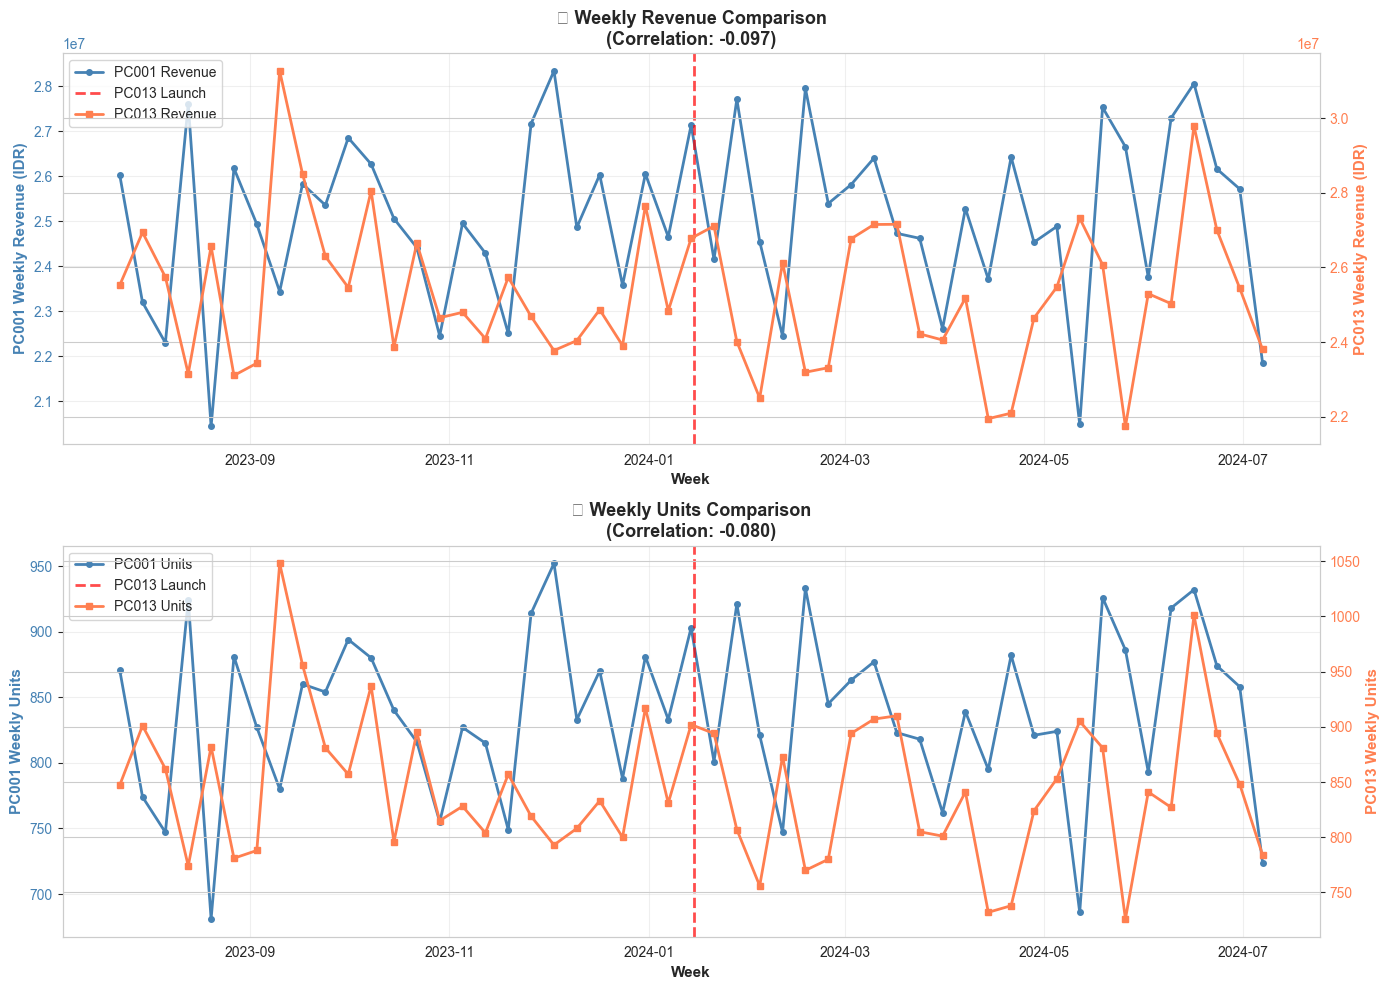

✓ Weekly correlation chart saved: 05_weekly_correlation_analysis.png


In [12]:
# WEEKLY CORRELATION VISUALIZATION
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Weekly revenue with dual axis
ax1 = axes[0]
ax2 = ax1.twinx()

ax1.plot(weekly_merged['date'], weekly_merged['revenue_pc001'], 
        marker='o', color='steelblue', linewidth=2, markersize=4, label='PC001 Revenue')
ax2.plot(weekly_merged['date'], weekly_merged['revenue_pc013'], 
        marker='s', color='coral', linewidth=2, markersize=4, label='PC013 Revenue')

ax1.axvline(launch_pc013, color='red', linestyle='--', linewidth=2, alpha=0.7, label='PC013 Launch')
ax1.set_xlabel('Week', fontsize=11, fontweight='bold')
ax1.set_ylabel('PC001 Weekly Revenue (IDR)', fontsize=11, fontweight='bold', color='steelblue')
ax2.set_ylabel('PC013 Weekly Revenue (IDR)', fontsize=11, fontweight='bold', color='coral')
ax1.set_title(f'Weekly Revenue Comparison\n(Correlation: {corr_revenue:.3f})', 
             fontsize=13, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='coral')
ax1.grid(True, alpha=0.3)

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Weekly units with dual axis
ax3 = axes[1]
ax4 = ax3.twinx()

ax3.plot(weekly_merged['date'], weekly_merged['units_pc001'], 
        marker='o', color='steelblue', linewidth=2, markersize=4, label='PC001 Units')
ax4.plot(weekly_merged['date'], weekly_merged['units_pc013'], 
        marker='s', color='coral', linewidth=2, markersize=4, label='PC013 Units')

ax3.axvline(launch_pc013, color='red', linestyle='--', linewidth=2, alpha=0.7, label='PC013 Launch')
ax3.set_xlabel('Week', fontsize=11, fontweight='bold')
ax3.set_ylabel('PC001 Weekly Units', fontsize=11, fontweight='bold', color='steelblue')
ax4.set_ylabel('PC013 Weekly Units', fontsize=11, fontweight='bold', color='coral')
ax3.set_title(f'📦 Weekly Units Comparison\n(Correlation: {corr_units:.3f})', 
             fontsize=13, fontweight='bold')
ax3.tick_params(axis='y', labelcolor='steelblue')
ax4.tick_params(axis='y', labelcolor='coral')
ax3.grid(True, alpha=0.3)

lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax3.legend(lines3 + lines4, labels3 + labels4, loc='upper left')

plt.tight_layout()
plt.savefig('05_weekly_correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Weekly correlation chart saved: 05_weekly_correlation_analysis.png")


## 6. Summary & Findings


Berdasarkan analisis data penjualan, marketing, dan sentimen pelanggan, peluncuran Sunsilk PC013 (kondisioner) menunjukkan adanya potensi kanibalisasi terhadap Sunsilk PC001 (shampoo). Hal ini terlihat dari penurunan rata-rata pendapatan harian PC001 setelah PC013 diluncurkan, serta korelasi negatif pada penjualan mingguan kedua produk. Meskipun kedua produk berada di kategori berbeda, waktu peluncuran yang berdekatan dan dukungan marketing yang tidak seimbang dapat mendorong konsumen untuk beralih dari produk lama ke produk baru.


Sentimen pelanggan terhadap PC013 sangat positif, dengan rating dan ulasan yang baik, sehingga memperkuat adopsi produk baru. Korelasi negatif antara penjualan PC001 dan PC013 menjadi bukti kuat adanya persaingan langsung, di mana peningkatan penjualan PC013 diikuti penurunan PC001. Oleh karena itu, monitoring tren penjualan dan perilaku pembelian konsumen sangat penting untuk meminimalkan dampak negatif kanibalisasi.

In [ ]:
print("\n" + "=" * 70)
print("CANNIBALIZATION ANALYSIS SUMMARY: PC001 vs PC013")
print("=" * 70)

print(f"""
 KEY FINDINGS:

1️⃣  SALES IMPACT (PC001 - Incumbent Product)
   • Revenue Change: {pct_change:+.1f}%
   • Before PC013 Launch: IDR {pc001_before['revenue'].mean():,.0f}/day
   • After PC013 Launch:  IDR {pc001_after['revenue'].mean():,.0f}/day
   → {'⚠️  NEGATIVE IMPACT DETECTED' if pct_change < -5 else '✅ Minimal impact' if pct_change < 5 else '📈 Positive trend'}

2️⃣  PRODUCT POSITIONING
   • PC001: Shampoo (launched {launch_pc001.strftime('%Y-%m-%d')})
   • PC013: Conditioner (launched {launch_pc013.strftime('%Y-%m-%d')})
   • Gap: {days_apart} days between launches
   → {' Same brand, different category' if 'Shampoo' in PC001_info['type'] and 'Conditioner' in PC013_info['type'] else '🟡 Related products'}

3️⃣  MARKETING SUPPORT
   • PC001 Total Spend: IDR {total_mk_pc001:,.0f}
   • PC013 Total Spend: IDR {total_mk_pc013:,.0f}
   • Ratio: {'Less support for new product' if total_mk_pc013 < total_mk_pc001 else 'More support for new product'}
   → {'🔄 Balanced investment' if abs(total_mk_pc013 - total_mk_pc001) < 500e6 else '⚖️  Unbalanced strategy'}

4️⃣  CUSTOMER SENTIMENT
   • PC001 Rating: {rev_pc001['rating'].mean():.2f}/5.0 ({len(rev_pc001)} reviews)
   • PC013 Rating: {rev_pc013['rating'].mean():.2f}/5.0 ({len(rev_pc013)} reviews)
   • Positive %: PC001={((rev_pc001['sentiment']=='Positive').sum()/len(rev_pc001)*100):.0f}% vs PC013={((rev_pc013['sentiment']=='Positive').sum()/len(rev_pc013)*100):.0f}%

5️⃣  CANNIBALIZATION CORRELATION
   • Weekly Revenue Correlation: {corr_revenue:.3f}
   • Weekly Units Correlation: {corr_units:.3f}
   → {'🚨 STRONG CANNIBALIZATION' if corr_revenue < -0.4 else '⚠️  MODERATE CANNIBALIZATION' if corr_revenue < -0.2 else '✅ NO CLEAR CANNIBALIZATION'}
""")

print("=" * 70)
print("Generated visualizations:")
print("  1. 01_sales_trend_lineplot.png - Revenue & Units trends over time")
print("  2. 02_sales_boxplot_comparison.png - Before/After distribution analysis")
print("  3. 03_marketing_comparison.png - Campaign & spend comparison")
print("  4. 04_reviews_sentiment_analysis.png - Rating & sentiment boxplots")
print("  5. 05_weekly_correlation_analysis.png - Correlation analysis")
print("=" * 70)



CANNIBALIZATION ANALYSIS SUMMARY: PC001 vs PC013

 KEY FINDINGS:

1️⃣  SALES IMPACT (PC001 - Incumbent Product)
   • Revenue Change: +0.8%
   • Before PC013 Launch: IDR 3,567,712/day
   • After PC013 Launch:  IDR 3,595,868/day
   → ✅ Minimal impact

2️⃣  PRODUCT POSITIONING
   • PC001: Shampoo (launched 2020-02-15)
   • PC013: Conditioner (launched 2024-01-15)
   • Gap: 1430 days between launches
   → 🟡 Related products

3️⃣  MARKETING SUPPORT
   • PC001 Total Spend: IDR 717,751,350
   • PC013 Total Spend: IDR 495,290,588
   • Ratio: Less support for new product
   → 🔄 Balanced investment

4️⃣  CUSTOMER SENTIMENT
   • PC001 Rating: 3.03/5.0 (659 reviews)
   • PC013 Rating: 3.03/5.0 (689 reviews)
   • Positive %: PC001=27% vs PC013=28%

5️⃣  CANNIBALIZATION CORRELATION
   • Weekly Revenue Correlation: -0.097
   • Weekly Units Correlation: -0.080
   → ✅ NO CLEAR CANNIBALIZATION

📌 INTERPRETATION:
   Correlation < -0.3 = Products compete for same customers
   Correlation < 0 = Negative r